In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_context('talk', font_scale=1)

import numpy as np
import scipy.stats as stats

import networkx as nx

In [3]:
import wordcloud

In [4]:
from Bio.Seq import Seq

In [5]:
def fdr(p_vals):
    ranked_p_values = stats.rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1
    return fdr

In [6]:
rep_motif_to_set_map = {}
motif_to_rep_map = {}

def rotate_motif(motif):
    return motif[-1] + motif[:-1]

def get_all_rotations(motif):
    rots = [motif]
    for _ in range(len(motif) - 1):
        rotated = rotate_motif(rots[-1])
        rots.append(rotated)
    return rots

def get_rep_motif(motif):
    if motif in motif_to_rep_map:
        return motif_to_rep_map[motif]
    
    motif_seq = Seq(motif)
    rev_comp = str(motif_seq.reverse_complement())
    
    rots = get_all_rotations(motif)
    rev_comp_rots = get_all_rotations(rev_comp)
    
    rep_set = rots + rev_comp_rots
    rep_set.sort()
    rep_motif = rep_set[0]
    
    for motif in rep_set:
        motif_to_rep_map[motif] = rep_motif
        
    rep_motif_to_set_map[rep_motif] = rep_set
    
    return rep_motif

def get_motif_gc_content(motif):    
    g = motif.count('G')
    c = motif.count('C')
    total = len(motif)
    return (g + c) / total

def get_motif_at_content(motif):    
    a = motif.count('A')
    t = motif.count('T')
    total = len(motif)
    
    return (a + t) / total

In [7]:
get_motif_at_content('AGGGCC')

0.16666666666666666

In [16]:
novel = pd.read_csv('../../resources/catalog_tsv_standard/novel_v01.tsv', sep='\t')
trf = pd.read_csv('../../resources/catalog_tsv_standard/trf.tsv', sep='\t')

novel['name'] = 'novel'
trf['name'] = 'trf'

novel['period'] = ((novel['stop'] - novel['start']) / novel['motif'].str.len()).astype(int)
trf['period'] = ((trf['stop'] - trf['start']) / trf['motif'].str.len()).astype(int)

# Group motifs
novel['rep_motif'] = novel['motif'].map(get_rep_motif)
trf['rep_motif'] = trf['motif'].map(get_rep_motif)
# novel['motif'] = novel['rep_motif']
# trf['motif'] = trf['rep_motif']

novel['gc_content'] = novel['rep_motif'].map(get_motif_gc_content)
novel['at_content'] = novel['rep_motif'].map(get_motif_at_content)
trf['gc_content'] = trf['rep_motif'].map(get_motif_gc_content)
trf['at_content'] = trf['rep_motif'].map(get_motif_at_content)

catalogs = pd.concat([novel, trf], ignore_index=True)

In [17]:
catalogs

,chr,start,stop,motif,LocusId,LocusStructure,ReferenceRegion,VariantId,VariantType,name,...,copyNum,consensusSize,perMatch,perIndel,score,A,C,G,T,entropy
0,chr1,13417,13421,GA,chr1_13417_13421,(GA)*,chr1:13417-13421,chr1_13417_13421,Repeat,novel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,15240,15252,GGGCCA,chr1_15240_15252,(GGGCCA)*,chr1:15240-15252,chr1_15240_15252,Repeat,novel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,16712,16727,TGG,chr1_16712_16727,(TGG)*,chr1:16712-16727,chr1_16712_16727,Repeat,novel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,30867,30891,CT,chr1_30867_30891,(CT)*,chr1:30867-30891,chr1_30867_30891,Repeat,novel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,31555,31570,AAAAT,chr1_31555_31570,(AAAAT)*,chr1:31555-31570,chr1_31555_31570,Repeat,novel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504145,chrY,57181121,57181156,TTTC,NaN,NaN,NaN,NaN,NaN,trf,...,8.8,4.0,90.0,9.0,54.0,0.0,20.0,0.0,80.0,0.72
504146,chrY,57196645,57196678,GCA,NaN,NaN,NaN,NaN,NaN,trf,...,11.0,3.0,93.0,0.0,57.0,33.0,30.0,36.0,0.0,1.58
504147,chrY,57202846,57202903,CAAAAA,NaN,NaN,NaN,NaN,NaN,trf,...,9.7,6.0,83.0,11.0,57.0,85.0,10.0,1.0,1.0,0.73
504148,chrY,57217316,57217414,GGGTGT,NaN,NaN,NaN,NaN,NaN,trf,...,16.3,6.0,82.0,17.0,116.0,0.0,0.0,63.0,36.0,0.95


In [18]:
novel['rep_motif'].nunique(), trf['rep_motif'].nunique()

(381, 377)

In [19]:
novel_counts = dict(novel.groupby('rep_motif').size())
trf_counts = dict(trf.groupby('rep_motif').size())

In [20]:
all_motifs = catalogs['rep_motif'].unique()
novel_total = len(novel)
trf_total = len(trf)
novel_total, trf_total

(270884, 233266)

In [21]:
p_enriched_all = []
p_depleted_all = []
n_novel = []
n_trf = []
motifs_to_remove = []
for i in range(len(all_motifs)):
    motif = all_motifs[i]
    novel_count = novel_counts[motif] if motif in novel_counts else 0
    trf_count = trf_counts[motif] if motif in trf_counts else 0
    n_novel.append(novel_count)
    n_trf.append(trf_count)
    
    if min(novel_count, trf_count) < 100:
        motifs_to_remove.append(i)
    
    table = [[novel_count, novel_total - novel_count],
             [trf_count, trf_total - trf_count]]
    odds_ratio, p_enriched = stats.fisher_exact(table, 'greater')
    odds_ratio, p_depleted = stats.fisher_exact(table, 'less')
    
    p_enriched_all.append(p_enriched)
    p_depleted_all.append(p_depleted)

In [22]:
data = pd.DataFrame({
    'rep_motif': list(all_motifs),
    'p_enriched': p_enriched_all,
    'p_depleted': p_depleted_all,
    'n_novel': n_novel,
    'n_trf': n_trf,
})

data = data.drop(motifs_to_remove, axis='rows')

In [23]:
data['q_enriched'] = fdr(data['p_enriched'])
data['q_depleted'] = fdr(data['p_depleted'])

In [24]:
data['q_enriched'].min(), data['q_depleted'].min()

(0.0, 0.0)

In [25]:
thresh = 0.05
sig = data[(data['q_enriched'] < thresh) & (data['q_depleted'] < thresh)]
enriched_sig = data[data['q_enriched'] < thresh]
depleted_sig = data[data['q_depleted'] < thresh]

In [26]:
len(enriched_sig), len(depleted_sig)

(16, 31)

In [27]:
', '.join(enriched_sig['rep_motif'])

'AG, ACC, AC, AT, ACAT, AATGG, AAATG, CCG, ACAG, ACCC, ACTC, AGGC, AAGC, ACCT, AATAT, AATT'

In [28]:
', '.join(depleted_sig['rep_motif'])

'AAAAT, AAAT, AAAG, AAAAG, AAAAC, AAGG, AGGG, AGAT, ATCC, AGG, AGGGG, ACAGAG, AATG, AAAAAC, AACC, AAC, AGAGG, AGAGGG, ACCATC, ACATAT, AAAAAG, AAATT, ATC, AAAGAG, ACACAT, AGGGGG, AAAGG, AAGGAG, AAAAAT, AAGGG, AGATAT'

In [29]:
enriched_sig['rep_motif'].str.len().mean(), enriched_sig['rep_motif'].str.len().median()

(3.6875, 4.0)

In [30]:
depleted_sig['rep_motif'].str.len().mean(), depleted_sig['rep_motif'].str.len().median()

(4.935483870967742, 5.0)

In [32]:
stats.ttest_ind(enriched_sig['rep_motif'].str.len(), depleted_sig['rep_motif'].str.len(), equal_var=False)

Ttest_indResult(statistic=-3.974535940212153, pvalue=0.00039440312907680484)

In [33]:
stats.ttest_ind(enriched_sig['rep_motif'].apply(get_motif_gc_content), depleted_sig['rep_motif'].apply(get_motif_gc_content), equal_var=False)

Ttest_indResult(statistic=0.8142860871073154, pvalue=0.42286637476081124)

In [34]:
stats.ttest_ind(novel['rep_motif'].apply(get_motif_gc_content), trf['rep_motif'].apply(get_motif_gc_content), equal_var=False)

Ttest_indResult(statistic=12.292362652265492, pvalue=1.0071796312225274e-34)

In [35]:
stats.ttest_ind(novel['rep_motif'].str.len(), trf['rep_motif'].str.len(), equal_var=False)

Ttest_indResult(statistic=-119.05456043883657, pvalue=0.0)

In [154]:
# to_predict = []
# for motif in sig['motif']:
#     novel_periods = novel.loc[novel['motif'] == motif, 'period']
#     trf_periods = list(trf.loc[trf['motif'] == motif, 'period'])
# #     periods = set(novel_periods + trf_periods)
# #     periods = set(novel_periods)
# #     for p in periods:
# #         to_predict.append(motif * p)
#     to_predict.append(motif * int(novel_periods.median()))

Text(0, 0.5, 'Fold Change')

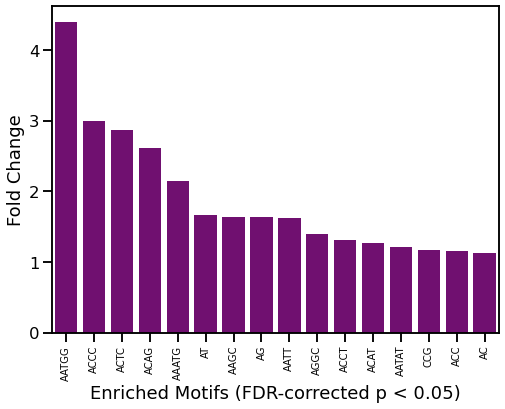

In [38]:
enriched = True

sig = enriched_sig.copy() if enriched else depleted_sig.copy()

sig = sig.head(20)

# novel_subset = novel[novel['motif'].isin(sig['motif'])]
# novel_pct_df = pd.DataFrame(novel_subset.groupby(['motif']).size() / len(novel)).reset_index()
# novel_pct_df = novel_pct_df.rename({0: 'percentage'}, axis='columns')
# novel_pct_df['name'] = 'novel'

# trf_subset = trf[trf['motif'].isin(sig['motif'])]
# trf_pct_df = pd.DataFrame(trf_subset.groupby(['motif']).size() / len(trf)).reset_index()
# trf_pct_df = trf_pct_df.rename({0: 'percentage'}, axis='columns')
# trf_pct_df['name'] = 'trf'

sig['pct_novel'] = sig['n_novel'] / len(novel)
sig['pct_trf'] = sig['n_trf'] / len(trf)
sig['metric'] = (sig['pct_novel'] / sig['pct_trf'])

# pct_df = pd.concat([novel_pct_df, trf_pct_df], ignore_index=True)
# pct_df['motif_len'] = pct_df['motif'].str.len()
# pct_df = pct_df.sort_values(['motif_len', 'motif'], ignore_index=True)

sig = sig.sort_values(['metric'], ignore_index=True, ascending=False if enriched else True)


fig, ax = plt.subplots(figsize=(8, 6))
# ax = sns.barplot(x="motif", y="metric", hue="name", data=pct_df, ax=ax)
ax = sns.barplot(x="rep_motif", y="metric", data=sig, ax=ax, color='purple')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_xlabel(('Enriched Motifs' if enriched else 'Top 20 Depleted Motifs') + ' (FDR-corrected p < 0.05)')
ax.set_ylabel('Fold Change')

<AxesSubplot:xlabel='Change', ylabel='Motif Length'>

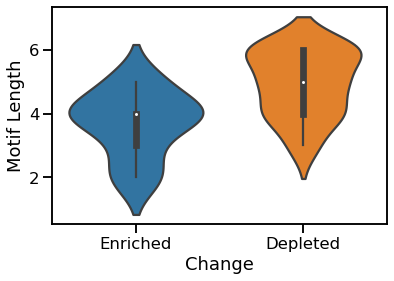

In [41]:
enriched_sig['Motif Length'] = enriched_sig['rep_motif'].str.len()
depleted_sig['Motif Length'] = depleted_sig['rep_motif'].str.len()
enriched_sig['Change'] = 'Enriched'
depleted_sig['Change'] = 'Depleted'
data = pd.concat([enriched_sig, depleted_sig], ignore_index=True)

sns.violinplot(x='Change', y='Motif Length', data=data)

In [85]:
subset = catalogs[catalogs['motif'].isin(sig['motif'])]
pd.DataFrame(subset.groupby(['motif', 'name']).size()).reset_index()

,motif,name,0
0,AAAAAC,novel,1064
1,AAAAAC,trf,4558
2,AAAAC,novel,4711
3,AAAAC,trf,9920
4,AAAAG,novel,2856
5,AAAAG,trf,4539
6,AAAAT,novel,4327
7,AAAAT,trf,7068
8,AAAG,novel,12170
9,AAAG,trf,12311


In [134]:
novel_subset = novel[novel['motif'].isin(sig['motif'])]
novel_pct_df = pd.DataFrame(subset.groupby(['motif']).size() / len(novel)).reset_index()
novel_pct_df = novel_pct_df.rename({0: 'percentage'}, axis='columns')
novel_pct_df['name'] = 'novel'

In [ ]:
novel_subset = novel[novel['motif'].isin(sig['motif'])]
novel_pct_df = pd.DataFrame(subset.groupby(['motif']).size() / len(novel)).reset_index()
novel_pct_df = novel_pct_df.rename({0: 'percentage'}, axis='columns')
novel_pct_df['name'] = 'novel'